# Week 7 Multi-Resolution Splines

### Date: 21 Nov 2024

Today we will be looking at blending images using multi-resolution splines. We will first start off by building a Gaussian pyramid, followed by a Laplacian Pyramid. We will then look at how to combine two Laplacian Pyramids to blend two images together to replicate the classic orange and apple image shown further down.



In [50]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# to visualize the plots within the notebook
%matplotlib inline

## Load images

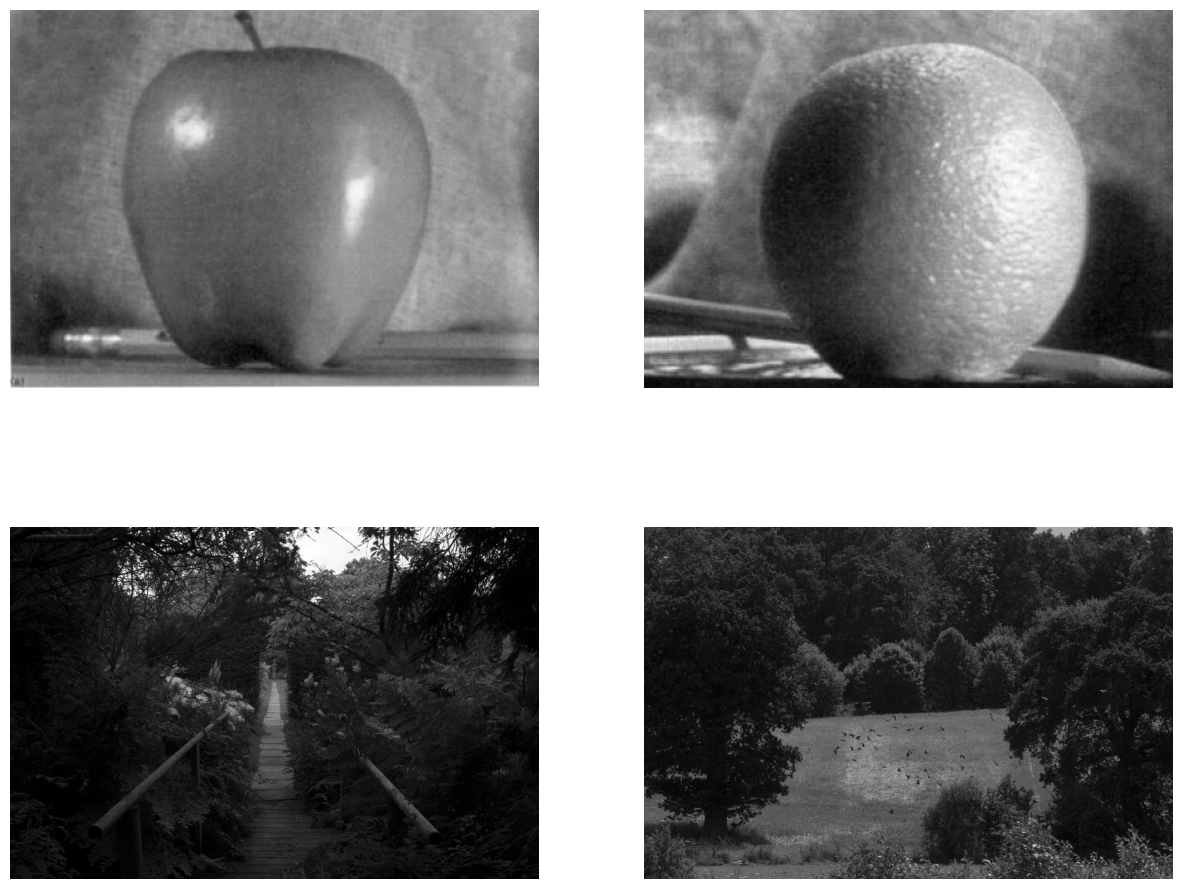

In [51]:
img1 = cv2.imread('../images/apple1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32)
img2 = cv2.imread('../images/orange1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
img3 = cv2.imread('../images/IMG_4825.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY).astype(np.float32)
img4 = cv2.imread('../images/IMG_5024.jpg')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY).astype(np.float32)
fig, axes = plt.subplots(2,2, figsize=(15,12))
axes[0,0].imshow(img1, "gray")
axes[0,0].set_axis_off()
axes[0,1].imshow(img2, "gray")
axes[0,1].set_axis_off()
axes[1,0].imshow(img3, "gray")
axes[1,0].set_axis_off()
axes[1,1].imshow(img4, "gray")
axes[1,1].set_axis_off()
plt.show()

## Task 1: Gaussian Pyramid


To build a Gaussian Pyramid	we will first need to create a method that will apply 2D convolution with a Gaussian kernel, which is defined as:

$$H_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

A Gaussian pyramid is then be built by convolving and down-sampling, giving us a sequence of low-pass filtered images $G_0, G_1, G_2, ..., G_n$:

<img src="../images/W7-Gaussian.png" alt="Gaussian Pyramid" width="500"/>

**Hint: You can use the functions you wrote in last week's lab for creating Gaussian kernel and applying 2D convolution. For up/down sampling, you can use `cv2.resize()`**

In [52]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""

def get_gaussian_kernel(h, w, sigma):

    y, x = np.meshgrid(np.linspace(-(h//2), h//2, h), np.linspace(-(w//2), w//2, w))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    return kernel/ kernel.sum()
    
def apply_filter(src_img, kernel):

    h, w = src_img.shape
    kh, kw = kernel.shape
    
    pad_h = (h - kh) // 2
    pad_w = (w - kw) // 2
    kernel_padded = np.pad(kernel, ((pad_h, h - kh - pad_h), (pad_w, w - kw - pad_w)), mode='constant')
    
    fft_img = np.fft.fft2(src_img)
    fft_kernel = np.fft.fft2(kernel_padded)

    fft_img_kernel = fft_img * fft_kernel
    filtered_img = np.fft.ifft2(fft_img_kernel).real
    filtered_img = np.fft.ifftshift(filtered_img)  # move the zero frequency component to the center
        
    return filtered_img


def apply_gaussian_filter(src_img, k=5, sigma=1.0):

    kernel = get_gaussian_kernel(k, k, sigma)
    return apply_filter(src_img, kernel)

"""
Implement your own PyrDown() and PyrUp() functions
"""
def myPyrDown(img, dstsize, k=5, sigma=1.0):
    
    # Apply Gaussian filter to the image
    filtered_img = apply_gaussian_filter(img, k, sigma)

    # Downsample by 2x
    downsampled_img = cv2.resize(filtered_img, dstsize)
    
    return downsampled_img

def myPyrUp(img, dstsize, k=5, sigma=1.0):

    # Scale up by 2x
    upsampled_img = cv2.resize(img, dstsize)
    
    # Apply Gaussian filter to interpolate missing values 
    upsampled_img = apply_gaussian_filter(upsampled_img, k, sigma)
    
    return upsampled_img
    
    

### Construct and visualize Gaussian Pyramids

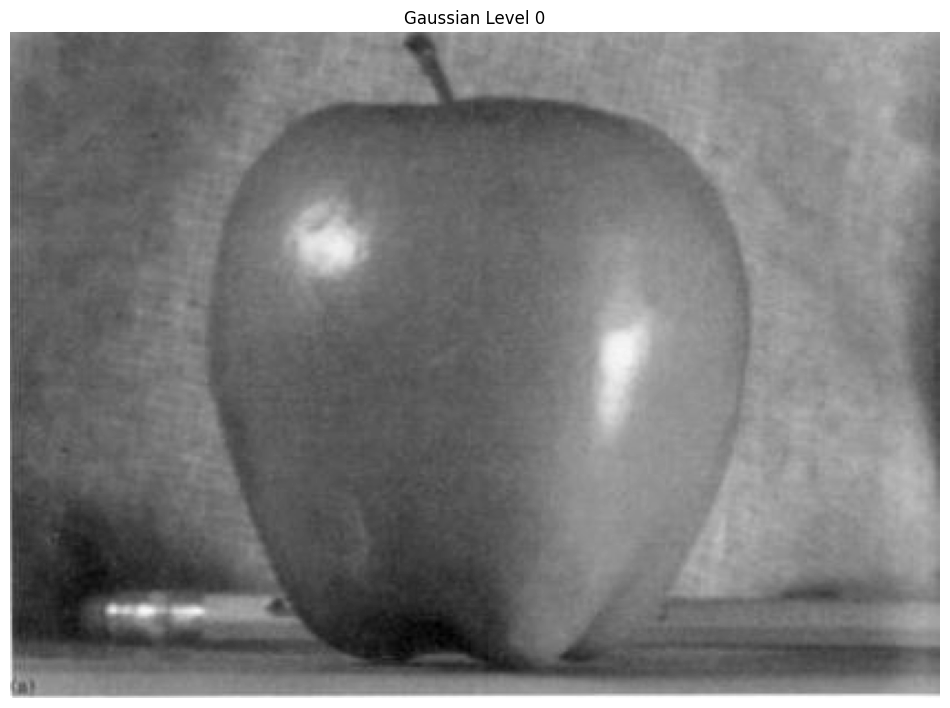

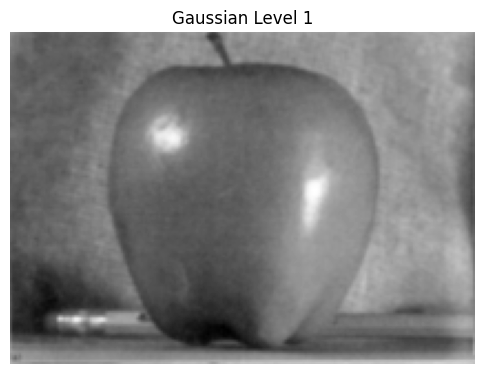

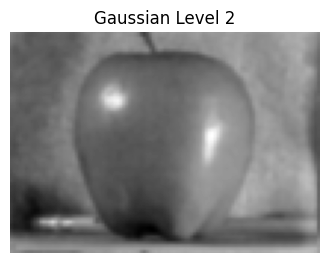

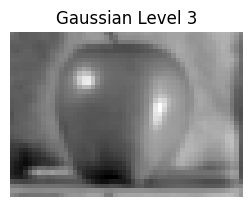

In [53]:
def make_gaussian_pyramids(img, max_level=3, k=5, sigma=1.0):
    gp = {}
    gp[0] = img
    for i in range(0, max_level):
        h, w = gp[i].shape
        dstsize = (w // 2, h // 2)
        gp[i+1] = myPyrDown(gp[i], dstsize, k, sigma) # Downsample the previous level
    return gp

# Visualize Gaussian Pyramids
def visualize_gaussian_pyramids(gp, fsize=12):
    num_levels = len(gp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(gp[l], "gray")
        plt.title("Gaussian Level {}".format(l))
        plt.axis('off')
    plt.show()

gp1 = make_gaussian_pyramids(img1)
visualize_gaussian_pyramids(gp1)

OK, seems like everything is working now, now try this to see  what you got:)

In [54]:
img_monroe = cv2.imread('../images/monroe.png')
img_monroe = cv2.cvtColor(img_monroe, cv2.COLOR_BGR2GRAY).astype(np.float32)

img_lincoln = cv2.imread('../images/lincoln.png')
img_lincoln = cv2.cvtColor(img_lincoln, cv2.COLOR_BGR2GRAY).astype(np.float32)

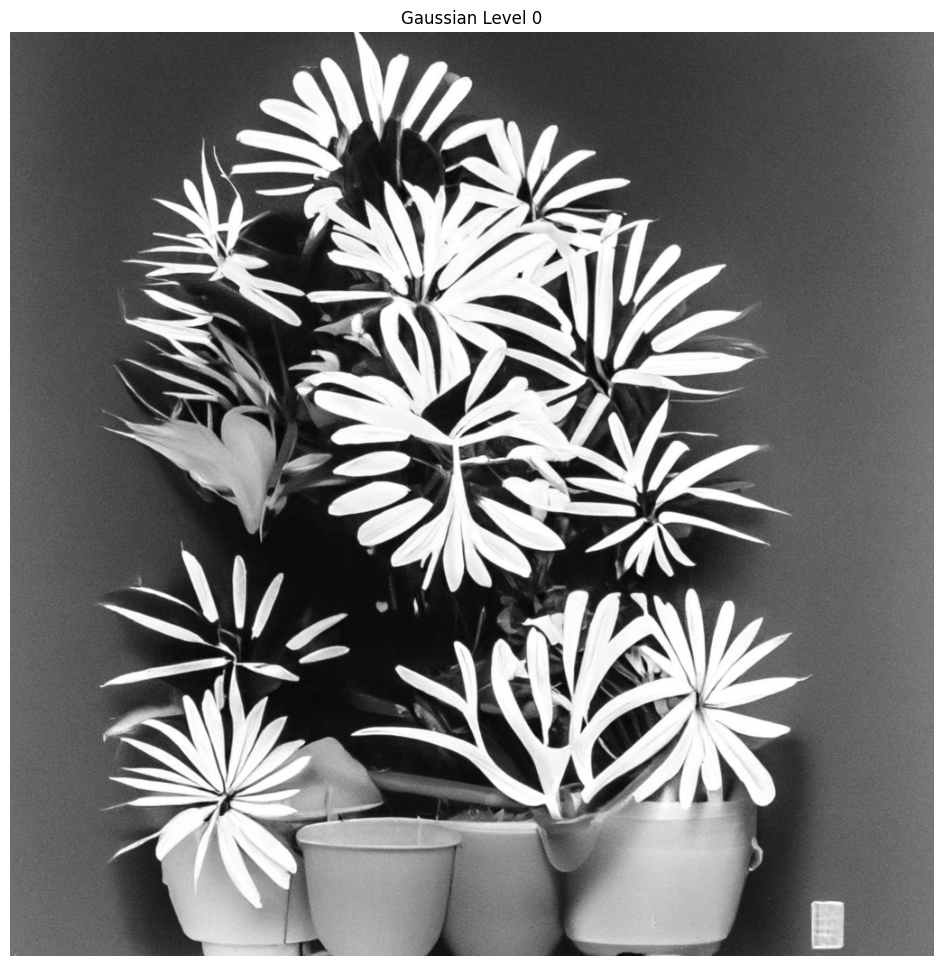

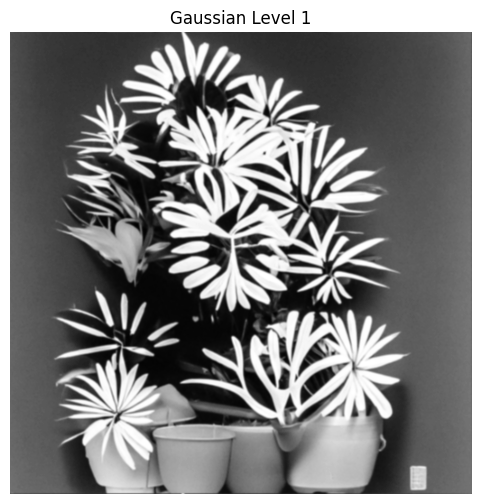

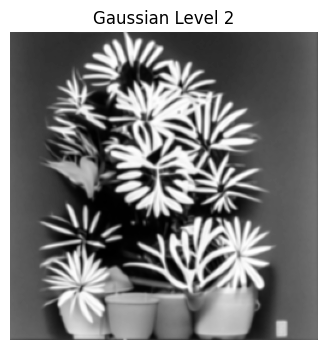

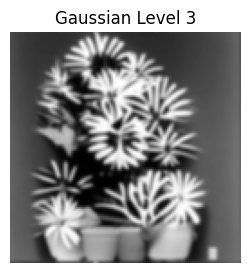

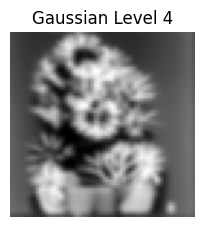

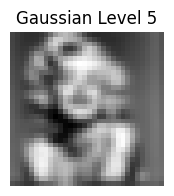

In [55]:
gp_monroe = make_gaussian_pyramids(img_monroe, max_level=5, sigma=2.0)
visualize_gaussian_pyramids(gp_monroe)

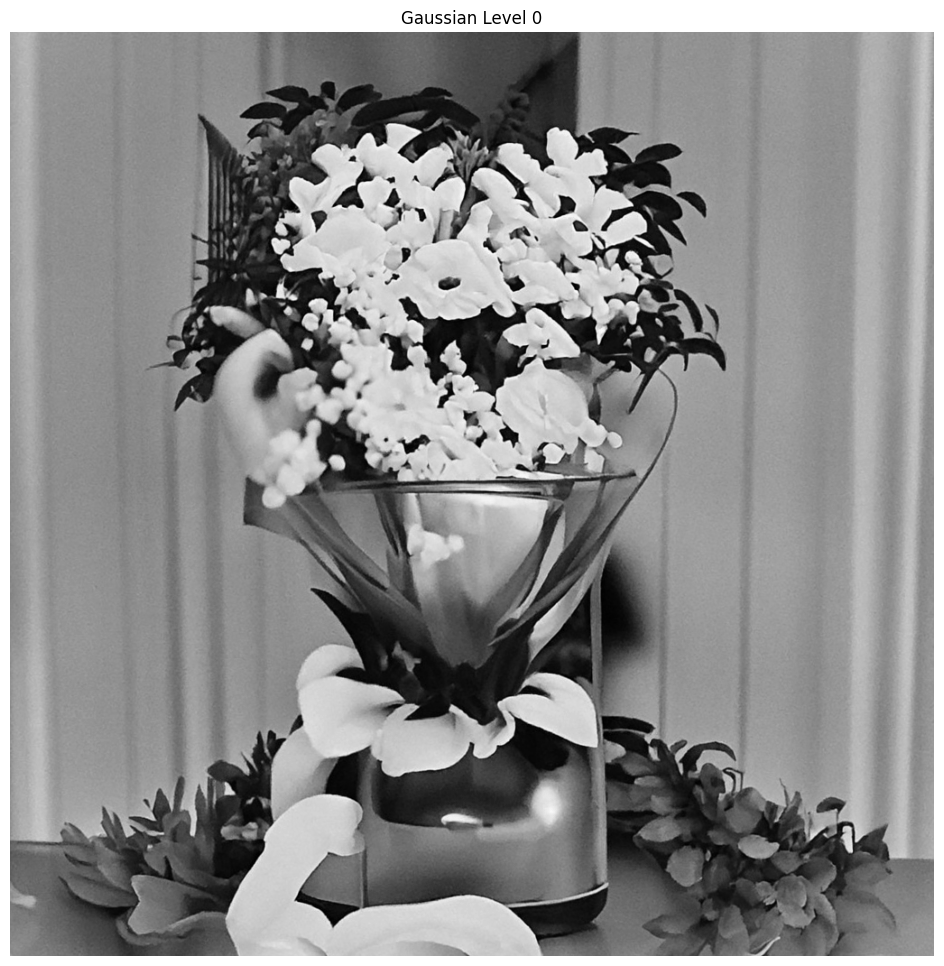

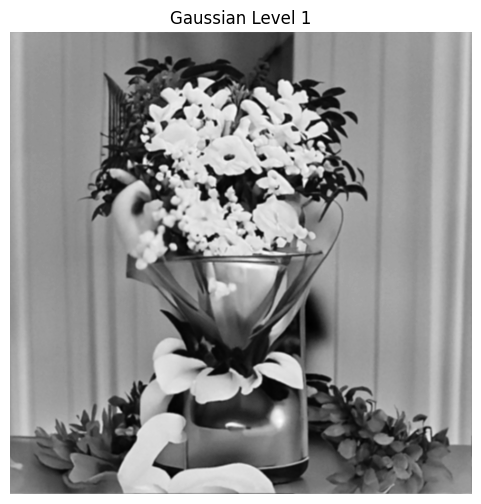

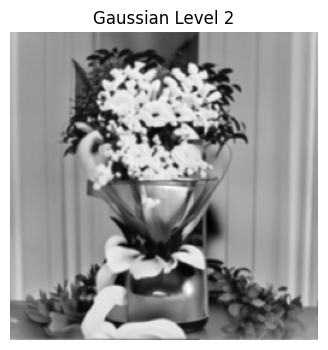

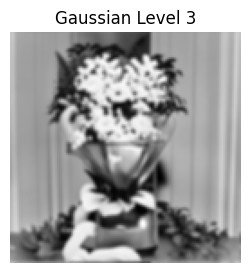

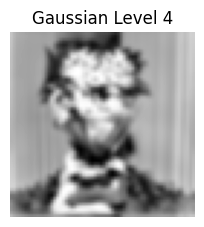

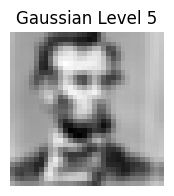

In [56]:
gp_lincoln = make_gaussian_pyramids(img_lincoln, max_level=5, sigma=2.0)
visualize_gaussian_pyramids(gp_lincoln)

## Task 2: Laplacian Pyramid

Next it’s time to build a (band-pass) Laplacian pyramid. This can be built using your Gaussian pyramid, each level will be	computed by	taking the difference from one level to the next, therefore:

$L_i = G_i - \text{EXPAND}(G_{i+1})$

Resulting in $L_0, L_1, L_2, ..., L_n$, where EXPAND() represents upsampling and then convolving with the same kernel you used before.

![Laplacian Pyramid](../images/W7-Laplacian.png)

### Construct and visualize Laplacian Pyramids

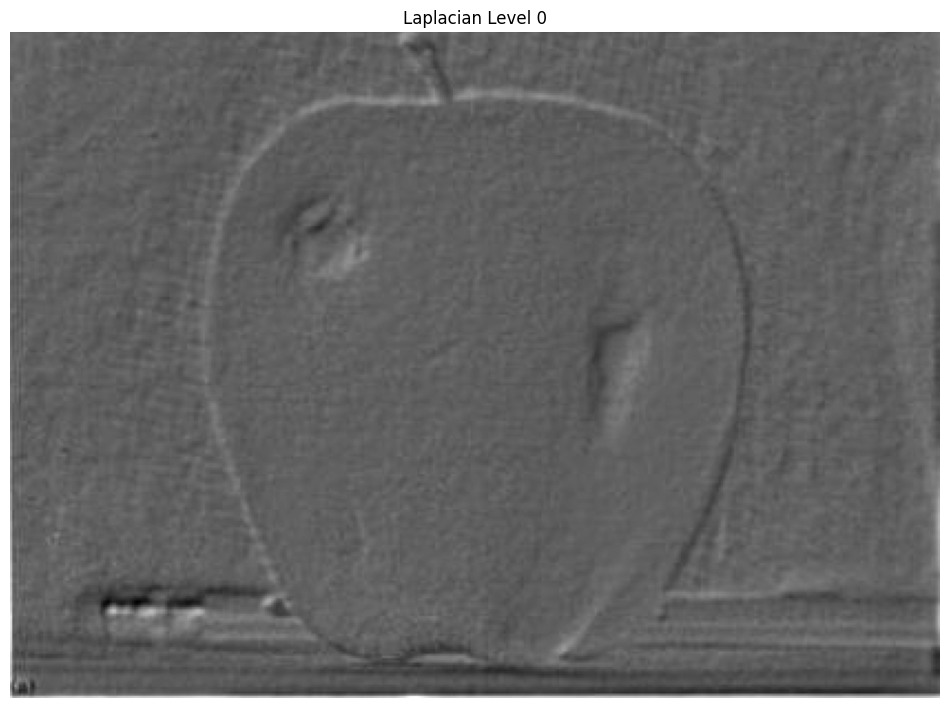

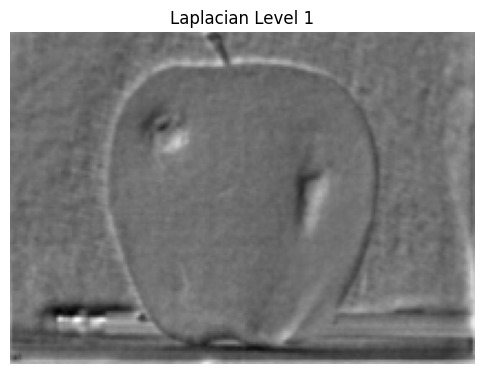

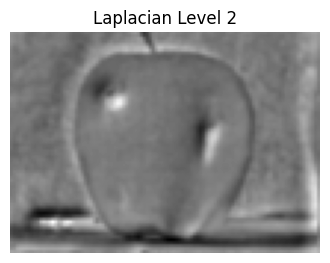

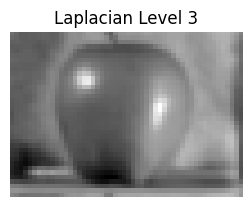

In [57]:
def make_laplacian_pyramids(gp):
    lp = {}
    """
    Implement a function that generates Laplacian Pyramids 
    param gp: Gaussian pyramid.
    return: Laplacian pyramid.
    """
    num_levels = len(gp.keys())
    for i in range (num_levels-1):
        h, w = gp[i].shape
        dstsize = (w, h)
        lp[i] = gp[i] - myPyrUp(gp[i+1], dstsize, 5, 1.0)
    lp[num_levels-1] = gp[num_levels-1] # Last level is the same as the last level of the Gaussian pyramid

    return lp

def visualize_laplacian_pyramids(lp, fsize=12):
    num_levels = len(lp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(lp[l], "gray")
        plt.title("Laplacian Level {}".format(l))
        plt.axis('off')
    plt.show()

lp1 = make_laplacian_pyramids(gp1)
visualize_laplacian_pyramids(lp1)

## Task 3: Image Blending with Multi-Resolution Spline

Once we have the methods that will create out Gaussian and Laplacian pyramids, we can use these to blend out images together using the following algorithm:

1) First compute the Laplacian pyramids $LA$ and $LB$ for images A and B

2) We then need to create a mask that will be used to blend out images. For this you can simply zeroing out the right half of the image.

3) Once we have a mask, we want to create a Gaussian pyramid of the mask, $GR$.

4) We now need to compute the Laplacian pyramid LS that is a combination of $LA$ and $LB$, computed by

$$LS_i = GR_iLA_i + (1-GR_i)LB_i$$

5) The pyramid LS now needs to be expanded, this is done by simply upscaling and adding each level from tom to bottom.

In [41]:
"""
Implement your functions here
"""
# Blend two Laplace Pyramids with given Gaussian Pyramids of the mask
def blend_laplacians(gp_mask, lp1, lp2):
    """
    Blend two Laplace Pyramids with given Gaussian Pyramids of the mask
    param gp_mask: Gaussian pyramid of the mask.
    param lp1: Laplacian pyramid of the first image.
    param lp2: Laplacian pyramid of the second image.
    return: Blended Laplacian pyramid.
    """
    
    num_levels = len(gp_mask.keys())
    bp = {}
    for i in range(num_levels):
        bp[i] = gp_mask[i] * lp1[i] + (1 - gp_mask[i]) * lp2[i]
    
    return bp
    

# Construct image with given Laplace Pyramids
def laplacian_collapse(lp):
    """
    Construct image with given Laplace Pyramids 
    param lp: Laplacian pyramid.
    return: Image.
    """
    num_levels = len(lp.keys())
    img = lp[num_levels-1]
    for i in range(num_levels-2, -1, -1):
        h,w = lp[i].shape
        img = lp[i] + myPyrUp(img, (w,h), 5, 1.0)
    return img

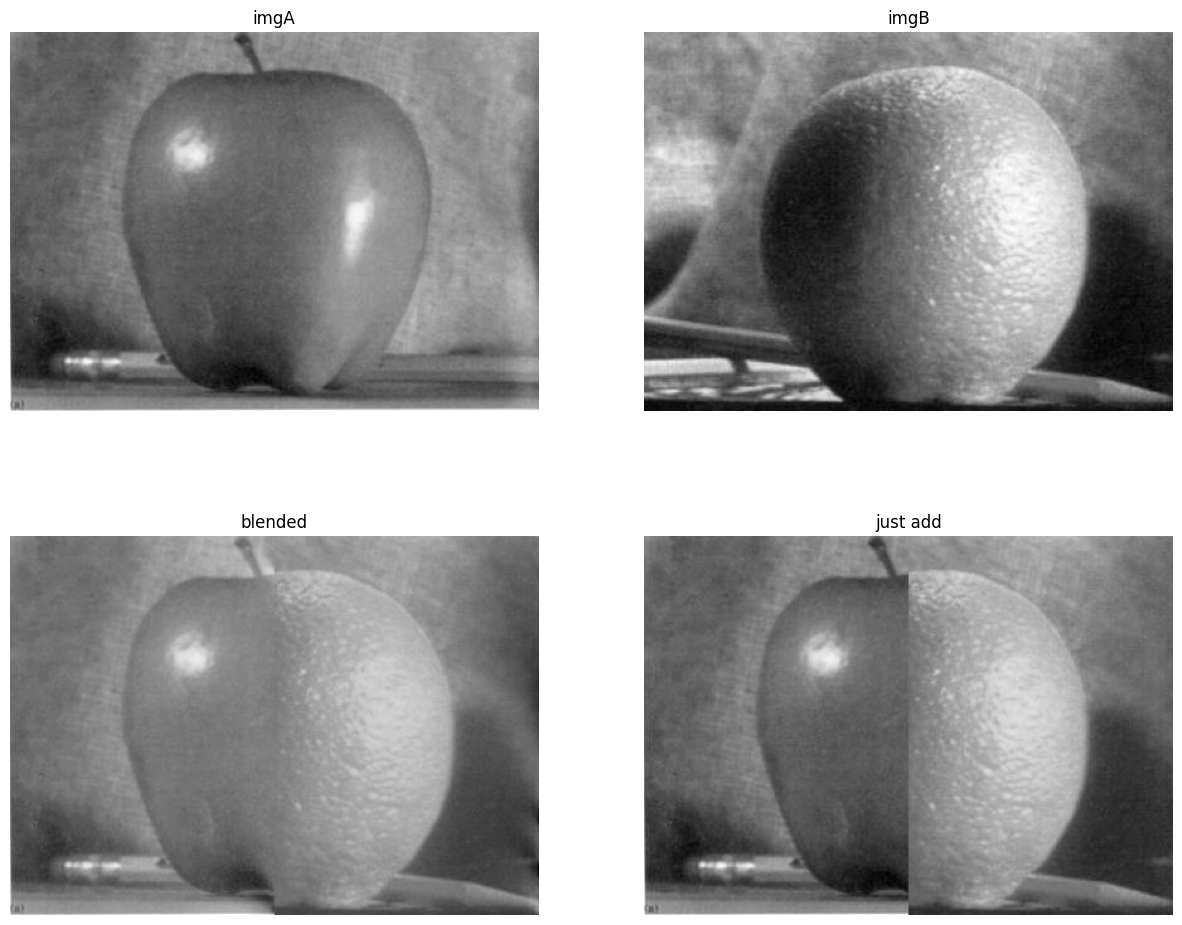

In [58]:
# Specify your imgA and imgB here
imgA, imgB = img1, img2

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0. # Right half is zero
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()

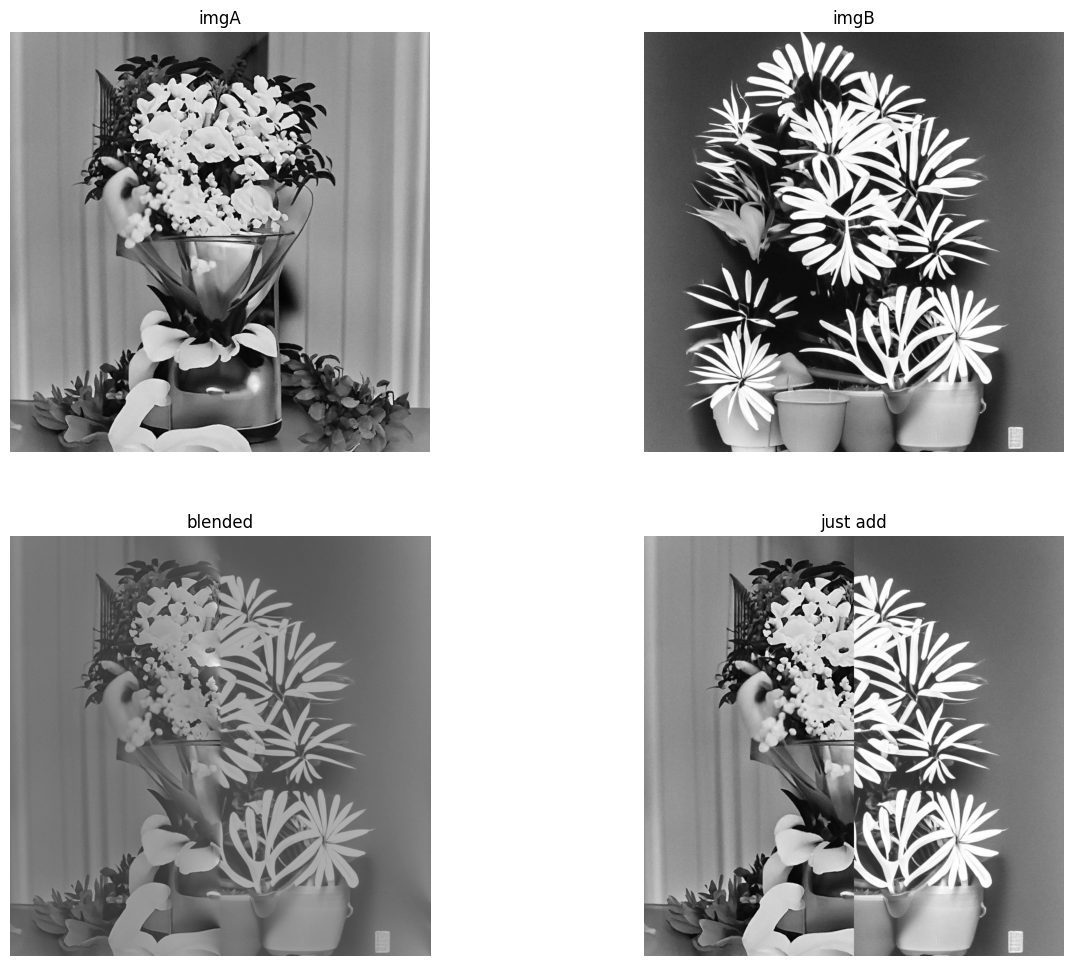

In [59]:
# Specify your imgA and imgB here
# imgA, imgB = img3, img4

### Try this one! ###
imgA, imgB = img_lincoln, img_monroe

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0.
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()

Those monroe and lincoln images are called hybrid images. This concept was firstly introduced in:

[1] Oliva et al. "Hybrid Images". ACM Transactions on Graphics (TOG), 2006.

Those images used here come from: 

[2] Geng et al. "Factorized Diffusion: Perceptual
Illusions by Noise Decomposition". In Proceedings of the European Conference on Computer Vision (ECCV), 2024.

If you are interested in this topic, you can read those papers to get more information.